#### モジュールのインポート等

In [1]:
import time
import random
import numpy as np
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline
DEBUG = 0
# JIS X 0201のカタカナのコード
JIS_code={166:'ヲ',167:'ァ',168:'ィ',169:'ゥ',170:'ェ',171:'ォ',172:'ャ',173:'ュ',174:'ョ',175:'ッ',176:'ー',177:'ア',178:'イ',179:'ウ',180:'エ',181:'オ',182:'カ',183:'キ',184:'ク',185:'ケ',186:'コ',187:'サ',188:'シ',189:'ス',190:'セ',191:'ソ',192:'タ',193:'チ',194:'ツ',195:'テ',196:'ト',197:'ナ',198:'ニ',199:'ヌ',200:'ネ',201:'ノ',202:'ハ',203:'ヒ',204:'フ',205:'ヘ',206:'ホ',207:'マ',208:'ミ',209:'ム',210:'メ',211:'モ',212:'ヤ',213:'ユ',214:'ヨ',215:'ラ',216:'リ',217:'ル',218:'レ',219:'ロ',220:'ワ',221:'ン',222:'゛',223:'゜'}

#### matplotlib で日本語を使用するため、日本語フォントの有無を確認

In [2]:
font_jp_exsits = True # 日本語フォント有無
font_jp = ('Yu Gothic','Meiryo UI','Hiragino Sans','Osaka','TakaoGothic','VL Gothic','IPAPGothic')
font_family_jp = {'family': font_jp}
for font in fm.findSystemFonts():
    if fm.FontProperties(fname=font).get_name() in font_jp:
        plt.rc('font', **font_family_jp)
        break
else:font_jp_exsits = False

#### ファイルからデータ（10608件）を抽出

In [3]:
# データファイル「（常用）手書カタカナ文字データベースＥＴＬ５」の読込
with open("ETL5C", "rb") as file : original_data = file.read()

# レコードに分割（10608件）
rec_bytes = 2952
records = [original_data[i:i+rec_bytes] for i in range(0, len(original_data), rec_bytes)]

# リサイズ後のイメージサイズを指定(元は 72×76)
img_sz_x, img_sz_y = 36, 38

# レコードからデータを抽出
data = np.zeros((len(records), img_sz_x*img_sz_y), dtype=np.int)   #_ shape = (#data, #feature)
target = np.zeros(len(records), dtype=np.int)                      #_ shape = (#data,)

for idx, record in enumerate(records) :
    # レコードからカタカナのJISコード(10Byte目) = 目的変数 を抽出
    target[idx] = record[9]
    
    # レコードから画像データ(216Byte以降)を抽出 (x:72px, y:76px, 4bit/px)
    img = Image.frombytes('F', (72, 76), record[216:], 'bit', 4).convert('L')
    img = np.asarray(Image.eval(img, lambda x: 255-x*16))

    # 処理速度を上げるためリサイズ
    img = np.array(Image.fromarray(img).resize((img_sz_x,img_sz_y)))    

    # 画像データはフラット化する
    data[idx] = img.reshape(img.shape[0]*img.shape[1])
    pass

#### 抽出した画像データを確認

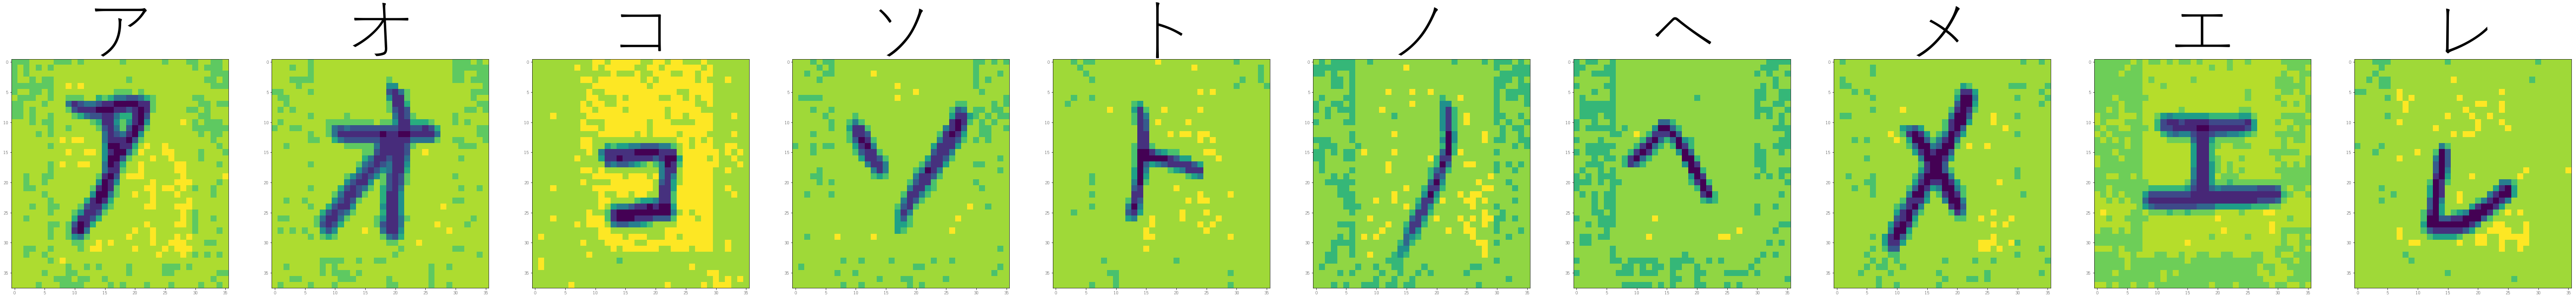

In [4]:
plt.figure(figsize=(100,10))
pos = 0
for i in range(1,10001,1000):
    pos += 1
    kana = JIS_code[target[i]]
    plt.subplot(1,10,pos)
    if font_jp_exsits:
        plt.title(kana,size=150)
    else:
        print(kana+'   ', end='')
    plt.imshow(data[i].reshape(img_sz_y,img_sz_x))
    pass

#### 複数モデルで性能を比較　<span style="color:IndianRed">※数分かかります</span>

In [5]:
print('Classifier            1000    2000    4000  |  time')
print('-------------------------------------------------------')
# 主要な分類器（NeuralNetwork以外のハイパーパラメータは全てデフォルトとする）
clfs = {'KNeighbors':KNeighborsClassifier(),
        'LogisticRegression':LogisticRegression(),
        'RandomForest':RandomForestClassifier(),
        'GaussianNB':GaussianNB(),
        'DecisionTree':DecisionTreeClassifier(),
        'AdaBoost':AdaBoostClassifier(),
        'NeuralNetwork':MLPClassifier(max_iter=500),
        'SupportVectorMachine':SVC(),}

# 分類器でループ
for name, clf in clfs.items():
    print('{:22}'.format(name), end='')
    # データ数でループ
    for i, data_num in enumerate([1000, 2000, 4000]):
        # トレーニング/テストデータを作成(テストデータは20％とする)
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=10)
        X_train = X_train[:data_num]
        X_test  = X_test[:data_num]
        y_train = y_train[:data_num]
        y_test  = y_test[:data_num]
        # トレーニング→テスト
        start = time.time()
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        print('{:.2f}{}'.format(score,' -> ' if i!=2 else ''), end='')
    print('  | {:5.1f} sec'.format(time.time()-start))
print('-------------------------------------------------------')

Classifier            1000    2000    4000  |  time
-------------------------------------------------------
KNeighbors            0.54 -> 0.63 -> 0.72  |  21.2 sec
LogisticRegression    0.63 -> 0.67 -> 0.71  | 119.0 sec
RandomForest          0.38 -> 0.50 -> 0.62  |   0.4 sec
GaussianNB            0.38 -> 0.48 -> 0.53  |   2.2 sec
DecisionTree          0.31 -> 0.40 -> 0.47  |   1.4 sec
AdaBoost              0.06 -> 0.08 -> 0.09  |   6.5 sec
NeuralNetwork         0.04 -> 0.04 -> 0.04  |  20.5 sec
SupportVectorMachine  0.04 -> 0.04 -> 0.04  |  55.6 sec
-------------------------------------------------------


#### 速度とスコアの良い RandomForest でグリッドサーチ　<span style="color:IndianRed">※20分程度かかります</span>

In [6]:
# データ数でループ
print('データ数  認識率   | 処理時間')
print('-----------------------------')
for data_num in [2000, 4000, 10000]:
    params = {
        'n_estimators' : [1400, 1500],
        'max_depth'    : [25, 26]
    }
    # トレーニング/テストデータを作成(テストデータは20％とする)
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=10)
    X_train = X_train[:data_num]
    X_test  = X_test[:data_num]
    y_train = y_train[:data_num]
    y_test  = y_test[:data_num]
    # グリッドサーチでトレーニング→テスト
    start = time.time()
    clf = GridSearchCV(RandomForestClassifier(), params, cv=2)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(' {:5}    {:.1f} %  | {:4.0f} sec'.format(data_num, score*100, time.time()-start))
    if DEBUG: print(clf.best_estimator_)
    if DEBUG: print(clf.best_params_)
    pass
print('-----------------------------')

データ数  認識率   | 処理時間
-----------------------------
  2000    75.4 %  |  143 sec
  4000    82.4 %  |  283 sec
 10000    87.7 %  |  870 sec
-----------------------------


#### 結果を視覚化

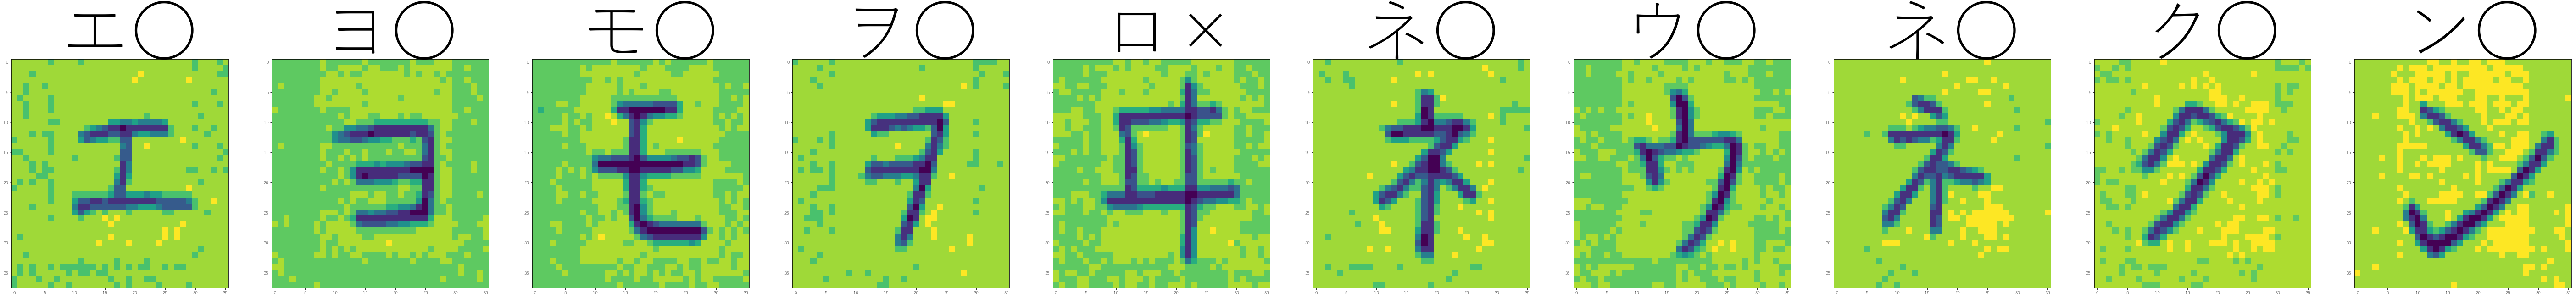

In [7]:
plt.figure(figsize=(100,10))
for i in range(10):
    ans  = JIS_code[y_test[i]]
    pred = JIS_code[clf.predict(X_test[i].reshape(1,X_test[i].shape[0]))[0]]
    result = '○' if ans==pred else '×'
    plt.subplot(1,10,i+1)
    if font_jp_exsits:
        plt.title(' '+pred+result,size=150)
    else:
        print('['+pred+']→'+result+'   ', end='')
    plt.imshow(X_test[i].reshape(img_sz_y,img_sz_x))
    pass